# Sentiment analysis of movie reviews

Links
* [Keras datasets](https://keras.io/datasets/)
* [Prepare data for text processing](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)
* [Keras embedding and tokenizer](http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/)
* [Pre-trained word embeddings in Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [28]:
import os
import numpy as np
import keras
from keras.datasets import imdb
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.preprocessing import sequence

from keras.activations import relu
from keras.activations import sigmoid
from keras.losses import binary_crossentropy
from keras.optimizers import adam

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D

from keras import backend as K

## Load and summarize data

Load the movie review data set

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()
print('There are {:,} training and {:,} test examples'.format(
    X_train.shape[0], X_test.shape[0]))

17465344/17464789 [==============================] - 1s 0us/step
There are 25,000 training and 25,000 test examples


In [6]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Get ratings for both training and test data

In [7]:
unique, counts = np.unique(y, return_counts=True)
ratings = dict(zip(unique, counts))
print('There are {r[0]:,} "0" ratings, and {r[1]:,} "1" ratings'.format(
    r=ratings))

There are 25,000 "0" ratings, and 25,000 "1" ratings


Get word to integer dictionary and create the inverse mapping

In [8]:
imdb_word_int = imdb.get_word_index()
imdb_int_word = {int_val:word for word, int_val in imdb_word_int.items()}

1646592/1641221 [==============================] - 0s 0us/step


Display the first review using only words. The punctuation has been removed

In [9]:
review_idx = 0
review_int = X_train[review_idx]
review_rating = y_train[review_idx]
review = ' '.join([imdb_int_word[int_val] for int_val in review_int])
print('rating {}'.format(review_rating))
review

rating 1


"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

Display the unique number of words in the data set

In [24]:
'{:,}'.format(len(np.unique(np.hstack(X))))

'88,585'

Calculate and display the typical length of reviews (in words)

Text(0.5,1,'histogram of review lengths')

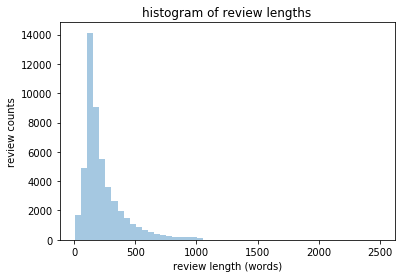

In [11]:
review_len = [len(review) for review in X]
g = sns.distplot(review_len, kde=False, axlabel='review length (words)')
g.set_ylabel('review counts')
g.set_title('histogram of review lengths')

## Word embeddings

Word embeddings is a technique where words are encoded as real-valued vectors in a high-dimensional space where the similarities of words translates to closeness in the vector space.

The Embeddings class in Keras is a convenient class to convert a positive integer to a word embedding

Load the imdb review data using only the 5000 most popular words

In [12]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

Truncate longer reviews to 500 words and zero-pad shorter reviews

In [13]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

## Fully connected model

Create the model

In [14]:
K.clear_session()
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(1, activation=sigmoid))
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


Train the model

In [21]:
epochs = 1
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
          batch_size=128, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 154s 6ms/step - loss: 0.2263 - acc: 0.9092 - val_loss: 0.2666 - val_acc: 0.8895


Calculate the model accuracy

In [22]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.95%


## Convolution model

Create the model

In [23]:
K.clear_session()

# set parameters:
batch_size = 32
embedding_dims = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 1

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(top_words, embedding_dims, input_length=max_words))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters, kernel_size, padding='valid', activation=relu, strides=1))
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, activation=relu))
model.add(Dropout(0.2))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 250)          24250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total para

Train the model

In [18]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 158s 6ms/step - loss: 0.4119 - acc: 0.7957 - val_loss: 0.2776 - val_acc: 0.8834


Calculate the model accuracy

In [20]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 88.34%


## Glove word embeddings

In [26]:
%%bash
pushd ~/.keras
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip glove.6B.100d.txt

~/.keras ~/code/notebooks/keras
Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       


--2017-12-19 06:57:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2017-12-19 06:57:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

     0K .......... .......... .......... .......... ..........  0%  247K 56m45s
    50K .......... .......... .......... .......... ..........  0%  741K 37m50s
   100K .......... .......... .......... .......... ..........  0%  743K 31m31s
   150K .......... .......... .......... .......... ..........  0% 85.2M 23m41s
   200K .......... .......... .......... .......... ..........  0%  745K 22m43s
   25

Build index of Glove embeddings

In [39]:
keras_home_dir = os.path.expanduser('~/.keras')
embeddings_index = {}
with open(os.path.join(keras_home_dir, 'glove.6B.100d.txt')) as f:
    for idx, line in enumerate(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Found {:,} word vectors'.format(len(embeddings_index)))

Found 400,000 word vectors


Build the embedding matrix

In [50]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((top_words, EMBEDDING_DIM))
for word, i in imdb_word_int.items():
    if i >= top_words:
        continue 
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Use the Glove embedding in the model

In [52]:
K.clear_session()
model = Sequential()
model.add(Embedding(top_words, EMBEDDING_DIM, input_length=max_words, weights=[embedding_matrix],
                    trainable=False))
model.add(Flatten())
model.add(Dense(250, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(1, activation=sigmoid))
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               12500250  
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 13,000,501
Trainable params: 12,500,501
Non-trainable params: 500,000
_________________________________________________________________
None


Train the model

In [53]:
epochs = 1
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
          batch_size=128, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 45s 2ms/step - loss: 0.7907 - acc: 0.5242 - val_loss: 0.6909 - val_acc: 0.5122


Calculate the model accuracy

In [54]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 51.22%
